In [31]:
import torch
device = 'cuda:0'
MODEL_ERA = '003000'
class MnistNet(torch.nn.Module):
    def __init__(self, c=1, m=[20, 20, 5]):
        super(MnistNet, self).__init__()
        self.m = m
        self.conv1 = torch.nn.Conv2d(c, self.m[0], 5, stride=1, padding=0)
        self.conv2 = torch.nn.Conv2d(self.m[0], self.m[1], 5, stride=1, padding=0)
        self.fc = torch.nn.Linear(4*4*self.m[1], m[2])
        self.scale = torch.nn.Parameter(torch.tensor(1.0))

    def forward(self, x):
        x = torch.nn.functional.relu(self.conv1(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = torch.nn.functional.relu(self.conv2(x))
        x = torch.nn.functional.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*self.m[1])
        x = self.fc(x)
        return x, self.scale*x

In [2]:
from scipy.stats import multivariate_normal
from skimage import restoration
from scipy.signal import fftconvolve
import numpy as np
# kernels
std = 3.0
f = np.vectorize(lambda x, y: multivariate_normal([0.0, 0.0], np.diag([std]*2)).pdf([x, y]))
X, Y = np.meshgrid(np.arange(-2, 3, 1, dtype=np.float32), np.arange(-2, 3, 1, dtype=np.float32))
kernel1 = f(X, Y)
kernel1 = kernel1 / kernel1.sum()
gauss_filt = kernel1

np.random.seed(0)
kernel2 = np.random.rand(*kernel1.shape)
kernel2 = kernel2 / kernel2.sum()
random_filt = kernel2

kernel3 = np.ones_like(kernel1)
kernel3 = kernel3 / kernel3.sum()
smoothed_filt = kernel3

# filters
filt = []
filt.append(lambda x: x)
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel1, mode='same')))
filt.append(lambda x: np.maximum(0, fftconvolve(x, kernel2, mode='same')))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel1, 1e-2)))
filt.append(lambda x: np.maximum(0, restoration.wiener(x, kernel2, 1e-2)))

In [3]:
T = 5

In [4]:
def restore_by_model(blur_img, policy):
    restore = torch.tensor(blur_img)
    for _ in range(T):

        action_idx = policy(restore, blur_img)
        action = filt[action_idx]
        restore = action(restore.numpy())
        restore = torch.from_numpy(restore)
    return restore.numpy()

In [32]:
# channel1 000
cond = ('channel01_weight000_seed00', 1)
net10 = MnistNet(c=cond[1], m=[20, 20, 5]).to(device)
net10.load_state_dict(torch.load('%s/Qnet%s.pth' % (cond[0], MODEL_ERA)))

def c01w000_policy(restore, blur_img):
    with torch.no_grad():
        q, _ = net10(restore[None, None, ...].to(device, dtype=torch.float))
    q = q.cpu().numpy()
    return np.argmax(q)

In [33]:
# channel1 005
cond =('channel01_weight005_seed00', 1)
net15 = MnistNet(c=cond[1], m=[20, 20, 5]).to(device)
net15.load_state_dict(torch.load('%s/Qnet%s.pth' % (cond[0], MODEL_ERA)))

def c01w005_policy(restore, blur_img):
    with torch.no_grad():
        q, _ = net15(restore[None, None, ...].to(device, dtype=torch.float))
    q = q.cpu().numpy()
    return np.argmax(q)

In [34]:
# channel2 000
cond = ('channel02_weight000_seed00', 2)
net20 = MnistNet(c=cond[1], m=[20, 20, 5]).to(device)
net20.load_state_dict(torch.load('%s/Qnet%s.pth' % (cond[0], MODEL_ERA)))

def c02w000_policy(restore, blur_img):
    blur_img = torch.from_numpy(blur_img)
    with torch.no_grad():
        feature = torch.stack([restore, blur_img])
        q, _ = net20(feature[None, ...].to(device, dtype=torch.float))
    q = q.cpu().numpy()
    return np.argmax(q)

In [35]:
# channel2 000
cond = ('channel02_weight005_seed00', 2)
net25 = MnistNet(c=cond[1], m=[20, 20, 5]).to(device)
net25.load_state_dict(torch.load('%s/Qnet%s.pth' % (cond[0], MODEL_ERA)))

def c02w005_policy(restore, blur_img):
    blur_img = torch.from_numpy(blur_img)
    with torch.no_grad():
        feature = torch.stack([restore, blur_img])
        q, _ = net25(feature[None, ...].to(device, dtype=torch.float))
    q = q.cpu().numpy()
    return np.argmax(q)

In [9]:
# random select 5 times
def restore_randomly(blur_img):
    restore = blur_img
    for _ in range(T):
        restore = filt[np.random.randint(0, T)](restore)
    return restore

def restore_by_c01w000(blur_img):
    return restore_by_model(blur_img, c01w000_policy)

def restore_by_c01w005(blur_img):
    return restore_by_model(blur_img, c01w005_policy)

def restore_by_c02w000(blur_img):
    return restore_by_model(blur_img, c02w000_policy)

def restore_by_c02w005(blur_img):
    return restore_by_model(blur_img, c02w005_policy)

In [10]:
import numpy as np
from torchvision import datasets
from train_agent import blur

# 実験手順
# 訓練で使っていない画像を準備
# ぼやかしたデータセットを作成
# 乱択した結果に対してMSEを記録
# 平均値を算出
def measure_MSE(restore_functions, kernel, c=3, trial_num=10000):
    data = datasets.MNIST(root='./data', train=False, download=True)
    test_imgs = data.data.numpy() / 255

    dataset_mse = []
    for img in test_imgs:
        blur_img = blur(img, kernel, c=c)
        case_mse = [np.mean((blur_img - img)**2)]        
        for restore_func in restore_functions:
            restore = restore_func(blur_img)
            mse = np.mean((restore - img)**2)
            case_mse.append(mse)
        dataset_mse.append(case_mse)
    return np.array(dataset_mse)

In [11]:
N = 10000

In [12]:
MODEL_ERA

'005500'

In [36]:
from tqdm.notebook import tqdm

functions = [
    restore_randomly,
    restore_by_c01w000,
    restore_by_c01w005,
    restore_by_c02w000,
    restore_by_c02w005
]

kernels = [
    ('gauss', gauss_filt),
    ('random', random_filt),
    ('smooth', smoothed_filt)
]

result_matrix = {}
for (label, kernel) in tqdm(kernels):
    c_matrix = []
    for c in tqdm(range(1, 6)):
        c_matrix.append(
            measure_MSE(functions, kernel, c, trial_num=N)
        )
    result_matrix[label] = c_matrix

In [37]:
import pickle
with open('compare_MSE(%s,%d).pickle' % (MODEL_ERA, N), 'wb') as f:
    pickle.dump(result_matrix, f)

In [44]:
from matplotlib import pyplot as plt
import pickle

with open('compare_MSE(003500,%d).pickle' % N, 'rb') as f:
    experiment50 = pickle.load(f)

with open('compare_MSE(020000,%d).pickle' % N, 'rb') as f:
    experiment400 = pickle.load(f)

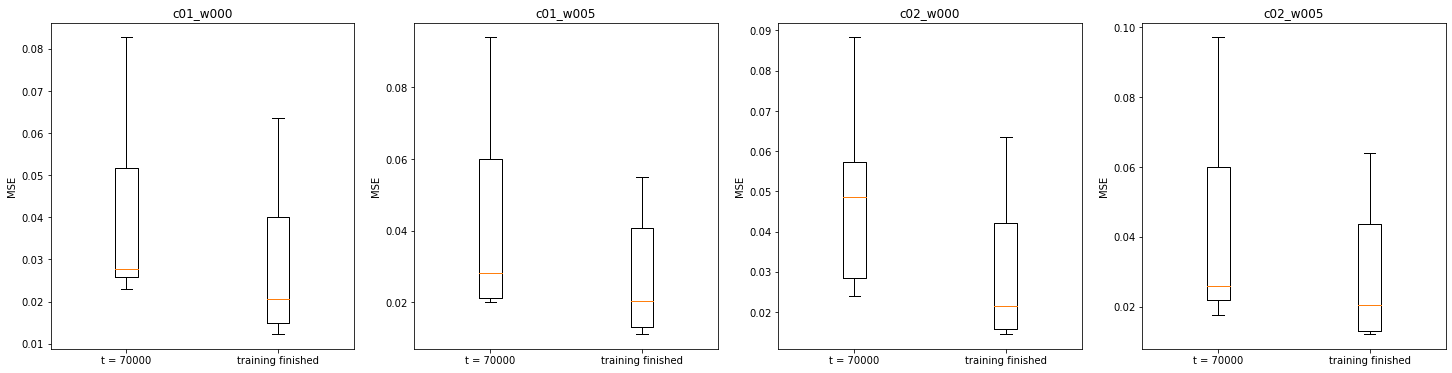

In [45]:
# gaussx3 c01w000 -> (1000, )
from matplotlib import pyplot as plt
labels = ['c01_w000', 'c01_w005', 'c02_w000', 'c02_w005']

def get_samples(m, j):
    samples = []
    for chunk_per_kernel in m.values():
        for i in range(5):
            samples.extend([chunk_per_kernel[i][:, j+2].mean() ])
    return samples

fig, axes = plt.subplots(1, 4, figsize=(25, 6))
FILT_COUNT = 2
for j in range(4):
    data = [get_samples(experiment50, j), get_samples(experiment400, j)]
    axes[j].set_title(labels[j])
    axes[j].tick_params()
    axes[j].boxplot(data)
    axes[j].set_ylabel('MSE')
    axes[j].set_xticklabels(['t = 70000', 'training finished'])
plt.show()

In [21]:
np.mean(get_samples(experiment400, 0))

0.027778980732195403

In [26]:
# result_matrixのデータ構造を変えたので、以下は動かない

In [22]:
# show
for key, res in result_matrix.items():
    for head in [key, 'init', 'random', 'c01w000', 'c01w005', 'c02w000', 'c02w005']:
        print(head, end='\t')
    print()
    for c, r in enumerate(res, start=1):
        print(c, '回', end='\t')
        result = r.mean(axis=0)
        for v in result:
            print(f'{v:.4f}', end='\t')
        print()
    print()

gauss	init	random	c01w000	c01w005	c02w000	c02w005	
1 回	0.0228	0.0423	0.0123	0.0111	0.0161	0.0161	
2 回	0.0341	0.0392	0.0139	0.0125	0.0146	0.0146	
3 回	0.0418	0.0408	0.0151	0.0139	0.0153	0.0153	
4 回	0.0472	0.0460	0.0205	0.0214	0.0216	0.0216	
5 回	0.0512	0.0517	0.0383	0.0399	0.0408	0.0408	

random	init	random	c01w000	c01w005	c02w000	c02w005	
1 回	0.0287	0.0400	0.0146	0.0128	0.0173	0.0173	
2 回	0.0385	0.0391	0.0148	0.0132	0.0153	0.0153	
3 回	0.0460	0.0449	0.0212	0.0204	0.0216	0.0216	
4 回	0.0511	0.0517	0.0421	0.0417	0.0433	0.0433	
5 回	0.0549	0.0572	0.0595	0.0523	0.0605	0.0605	

smooth	init	random	c01w000	c01w005	c02w000	c02w005	
1 回	0.0303	0.0385	0.0149	0.0128	0.0176	0.0176	
2 回	0.0396	0.0395	0.0150	0.0137	0.0156	0.0156	
3 回	0.0473	0.0464	0.0233	0.0243	0.0244	0.0244	
4 回	0.0523	0.0532	0.0476	0.0464	0.0491	0.0491	
5 回	0.0560	0.0585	0.0635	0.0549	0.0635	0.0635	



In [58]:
# tex
for key, res in experiment400.items():
    for head, row in zip(['init', 'random', 'c01w000', 'c01w005', 'c02w000', 'c02w005'], np.stack(res).T):
        print(head, end='')
        r = row.mean(axis=0)
        for val in r:
            print(' & ', end='')
            print('%.3f' % round(val, 3), end=' ')
        print('\\\\ \hline')
    print()

init & 0.023  & 0.034  & 0.042  & 0.047  & 0.051 \\ \hline
random & 0.043  & 0.039  & 0.041  & 0.046  & 0.051 \\ \hline
c01w000 & 0.012  & 0.014  & 0.015  & 0.021  & 0.038 \\ \hline
c01w005 & 0.011  & 0.013  & 0.014  & 0.021  & 0.040 \\ \hline
c02w000 & 0.016  & 0.015  & 0.015  & 0.022  & 0.041 \\ \hline
c02w005 & 0.013  & 0.013  & 0.014  & 0.022  & 0.043 \\ \hline

init & 0.029  & 0.038  & 0.046  & 0.051  & 0.055 \\ \hline
random & 0.040  & 0.039  & 0.045  & 0.052  & 0.057 \\ \hline
c01w000 & 0.015  & 0.015  & 0.021  & 0.042  & 0.059 \\ \hline
c01w005 & 0.013  & 0.013  & 0.020  & 0.042  & 0.052 \\ \hline
c02w000 & 0.017  & 0.015  & 0.022  & 0.043  & 0.060 \\ \hline
c02w005 & 0.012  & 0.013  & 0.020  & 0.045  & 0.061 \\ \hline

init & 0.030  & 0.040  & 0.047  & 0.052  & 0.056 \\ \hline
random & 0.039  & 0.040  & 0.046  & 0.053  & 0.058 \\ \hline
c01w000 & 0.015  & 0.015  & 0.023  & 0.048  & 0.064 \\ \hline
c01w005 & 0.013  & 0.014  & 0.024  & 0.046  & 0.055 \\ \hline
c02w000 & 0.018  &